# Deep Density Destructors

In this notebook, I would like to investigate how RBIG compares to the Deep Density Estimator (DDD) framework. There is a software [package](https://github.com/davidinouye/destructive-deep-learning) that stems from the paper of the same name that seeks to try and harmonize all of the density estimators. The notion is as follows: we have some data distribution $\mathcal P_x$ and we wish to find some transformation $D_\theta(\mathbf x)$ which seeks to approximate a base distribution $\mathbf z$. Now, this base distribution could be anything and most people would use a normal distribution. However, the authors here argue that a way to link different sequences of transformations together, we must use a "canonical" destructor which projects the data onto the unit Hypercube $\mathcal U [0,1]^d$. So theoretically, we can link any series of transforms $\mathbf D_{\theta,1}$ together. But to append other  sequencees of transforms $\mathbf D_{\theta,2}$ to this series, then we need to ensure that the final transformation mapped the data to unit HyperCube. 

One key advantage to this method is the calculation of the probabilities. Since the final base approximation is a normal distribution with probability 1 in all domains, the calculation of $\mathcal P_x(\mathbf x)$ is simplified. So more concretely

$$\mathcal P_x(\mathbf x) = \mathcal P_z\left (\mathbf D(\mathbf z) \right) \left| \nabla \mathbf D_\theta \right| = \left| \nabla \mathbf D_\theta \right|$$

This means we just have to calculate the sequence of Jacobians leading up to that calculation. Now the authors compared their approach to RBIG because RBIG (in a sense) is also a destructor. However, we don't do anything with the canonical destructor. We do not bound any of our calculations to a unit HyperCube explicitly. They have an extra step in all of their code (which we will see later) is called `IndependentDestructor()`. This maps the data to the unit hyperCube. This notebook will seek to investigate the claims that there is indeed a difference in what we do versus what they do.

One a side note, the author's code is really good! He really broke down the process of deep destructive learning into really sizeable chunks that made it really easy to understand exactly what's going on under the scenes. I really like his code base and I do plan to see if I can convert some of these techniques when I eventually code the RBIG code into the PyTorch deep learning framework.

### Definitions

**Destructors**: Invertible transformations. Each destructor has an explicit or an implicit density which has some probabilistic density which is 

$$\mathcal P_x(\mathbf x) = \left| \text{det} \nabla D_\theta \right|$$

**Canonical Destructor**: Invertible transformations that project onto the unit hypercube.

**Implicit Density**:

**Explicit Density**:


### Algorithms

* RBIG
* Randomized Linear Canonical Model
* Deep Gaussian Copula Model

#### Table of Contents

* Destructors - Invertible Transforms
    * Uniform, Marginal Gaussianization
* Canonical Destructors - Invertible Transforms that project onto 
    * 
* 

In [1]:
# Setup imports
from __future__ import division, print_function
import sys, os, warnings
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
sys.path.append('..')  # Enable importing from package ddl without installing ddl

In [103]:
from ddl.linear import RandomOrthogonalEstimator
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings("ignore", category=DataConversionWarning)
from ddl.tree import TreeDensity, TreeDestructor, RandomTreeEstimator
from sklearn.base import BaseEstimator, TransformerMixin
from ddl.deep import DeepDestructorCV, DeepDestructor

from ddl.independent import IndependentDensity, IndependentDestructor
from ddl.univariate import HistogramUnivariateDensity
import scipy.stats
from sklearn.decomposition import PCA
from sklearn.base import clone
from ddl.univariate import HistogramUnivariateDensity, ScipyUnivariateDensity
from ddl.independent import IndependentInverseCdf
from ddl.linear import LinearProjector
from ddl.base import CompositeDestructor

In [209]:
def plot_scatter(data, probs=None):
    fig, ax = plt.subplots()
    if probs is not None:
        h = ax.scatter(data[:, 0], data[:, 1], s=1, c=probs)
        cbar = plt.colorbar(h)

    else:
        ax.scatter(data[:, 0], data[:, 1], s=1)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Data')
    plt.tight_layout()

    plt.show()
    return None

def plot_histograms(data, bins=50):
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    ax[0].set_title(r'$X$')
    ax[0].hist(data[:, 0], bins=50)
    ax[1].set_title(r'$Y$')
    ax[1].hist(data[:, 1], bins=50)
    plt.tight_layout()
    plt.show()
    
    return None

def plot_layer_scores(scores):
    
    # Score Layers
    fig, ax = plt.subplots()

    ax.plot(score_layers.cumsum())

    plt.show()
    
    return None

## Data

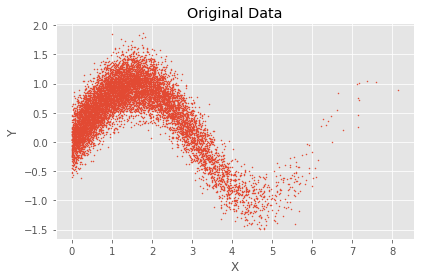

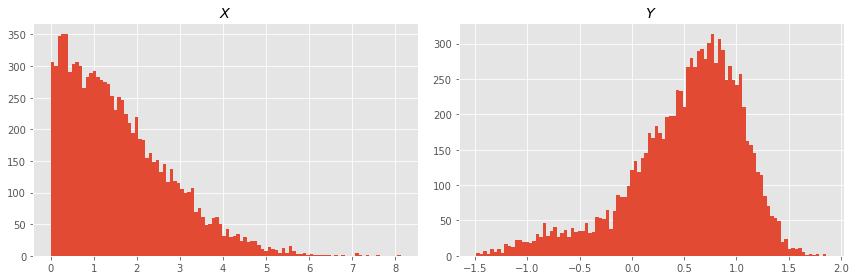

In [210]:
seed = 123
rng = np.random.RandomState(seed=seed)

num_samples = 10000
x = np.abs(2 * rng.randn(num_samples, 1))
y = np.sin(x) + 0.25 * rng.randn(num_samples, 1)
data = np.hstack((x, y))

# Scatter Data
fig, ax = plt.subplots()
ax.scatter(data[:, 0], data[:, 1], s=1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Original Data')
plt.tight_layout()

plt.show()

# Histograms
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
ax[0].hist(data[:, 0], bins=100)
ax[0].set_title(r'$X$')
ax[1].hist(data[:, 1], bins=100)
ax[1].set_title(r'$Y$')
plt.tight_layout()
plt.show()

## RBIG Algorithm: Step-by-Step

The RBIG algorithm consists of three steps if you break up the algorithm components completely.

1. Fit a Univariate Histogram to each dimension separately (Marginal Uniformization)
2. Fit a Gaussian to each dimension separately (Marginal Gaussianization)
3. Rotate the Components

We have a different stopping criteria which is based off of the information content that gets reduced as you transform the distribution and it becomes more and more Gaussian. They use the likelihood which is implicit since their canonical transformation ends in the unit hypercube.

#### Step I - Marginal Uniformization

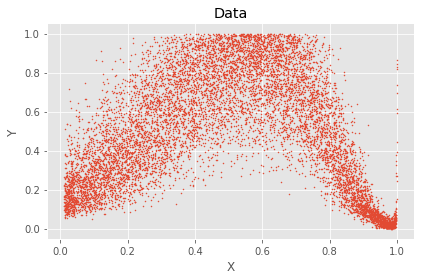

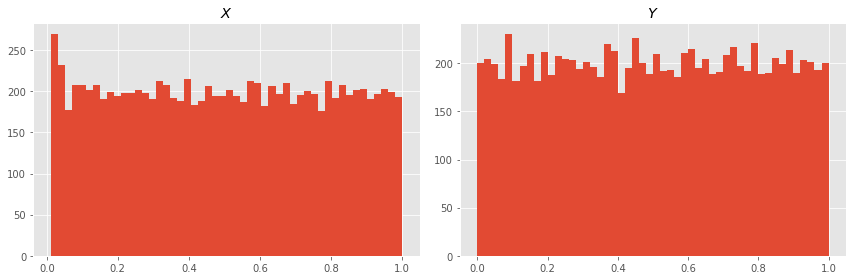

In [272]:
# Parameters
bins = 'auto'       # bin estimation (uses automatric method)
bounds = 0.01       # percentage extension of the support
alpha = 1e-10       # regularization parameter for hist (not needed for RBIG)

# Choose the Histogram estimator that converts the data X to uniform U(0,1)
univariate_estimator = HistogramUnivariateDensity(bounds=bounds, bins=bins, alpha=alpha)

# Marginally uses histogram estimator
marginal_uniformization = IndependentDensity(
    univariate_estimators= univariate_estimator,
)

# Creates "Destructor" D_theta_1
uniform_density = IndependentDestructor(marginal_uniformization)

# Fit and transform data P_x ---> U_z
mU_approx = uniform_density.fit_transform(data)

# Sampling

# Data Together
plot_scatter(mU_approx)

# Histograms
plot_histograms(mU_approx)

#### Step II - Marginal Gaussianization

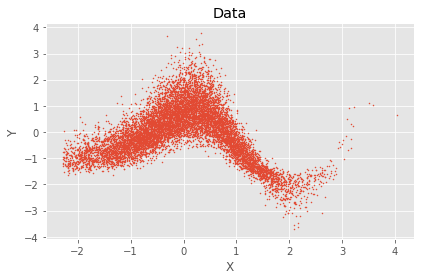

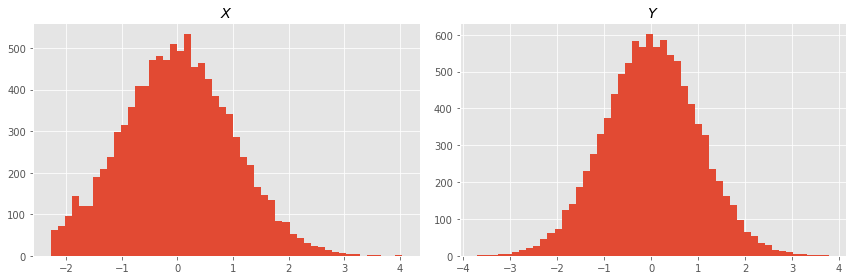

In [273]:


# Choose destructor D_theta_2 that converts data
marginal_gaussianization = IndependentInverseCdf()


#  U_z ---> G_z
mG_approx = marginal_gaussianization.fit_transform(mU_approx)

# Fit and transform data Data Together
plot_scatter(mG_approx)

# Histograms
plot_histograms(mG_approx)

### Step III - Rotation

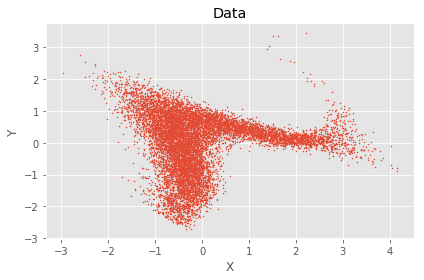

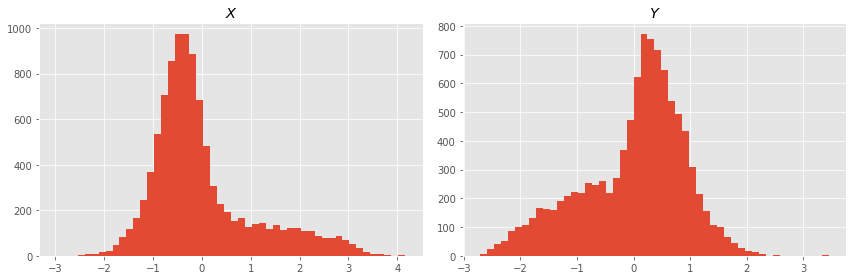

In [274]:
# Choose a linear projection to rotate the features (PCA) "D_theta_3"
rotation = LinearProjector(linear_estimator=PCA())


# Fit and transform data G_z ----> R (G_z)
G_approx = rotation.fit_transform(mG_approx)

# Data Together
plot_scatter(G_approx)

# Histograms
plot_histograms(G_approx)

#### Step IV - Canonical Transformation

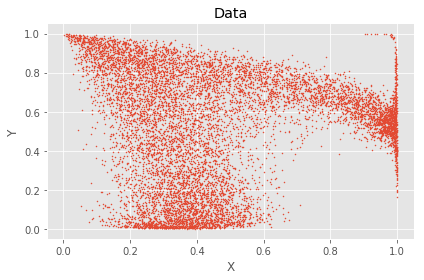

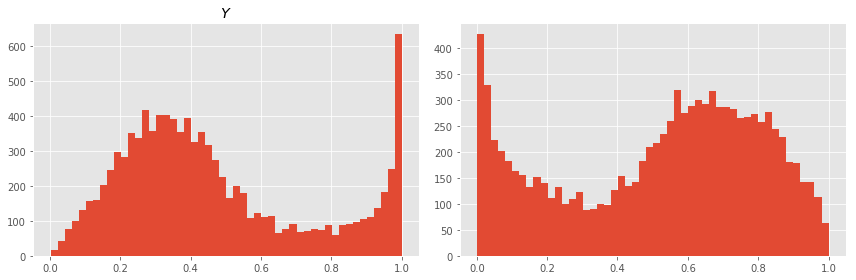

In [204]:
C_approx = IndependentDestructor().fit_transform(G_approx)


# Data Together
plot_scatter(C_approx)

# Histograms
plot_histograms(C_approx)

### RBIG - Composite Destructor (1 Layer)

Score: 0.6671562314266752


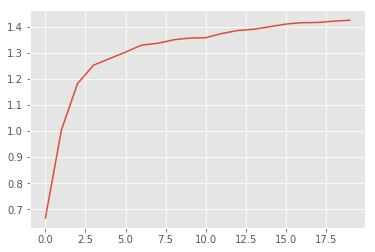

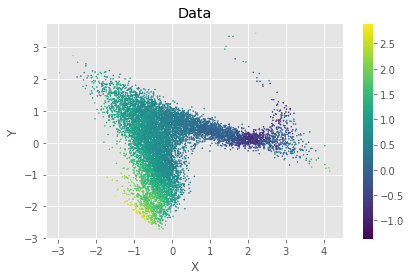

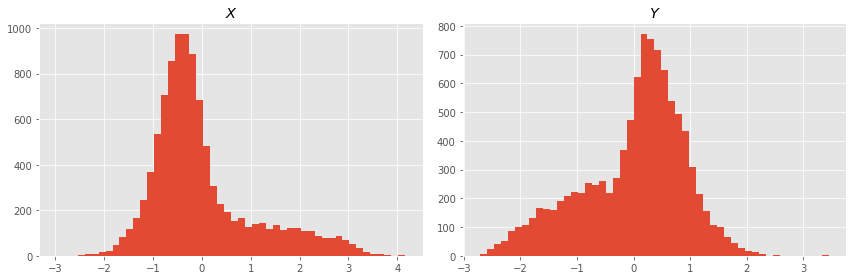

CPU times: user 1.43 s, sys: 24.6 ms, total: 1.46 s
Wall time: 1.33 s


In [211]:
%%time

# Parameters
bins = 'auto'       # bin estimation (uses automatric method)
bounds = 0.01       # percentage extension of the support
alpha = 1e-10       # regularization parameter for hist (not needed for RBIG)

# ================================ #
# Step I - Marginal Uniformization
# ================================ #

# Choose the Histogram estimator that converts the data X to uniform U(0,1)
univariate_estimator = HistogramUnivariateDensity(bounds=bounds, bins=bins, alpha=alpha)

# Marginally uses histogram estimator
marginal_uniformization = IndependentDensity(
    univariate_estimators= univariate_estimator,
)

# Creates "Destructor" D_theta_1
uniform_density = IndependentDestructor(marginal_uniformization)

# ================================== #
# Step II - Marginal Gaussianization
# ================================== #

# Choose destructor D_theta_2 that converts data
marginal_gaussianization = IndependentInverseCdf()

# =================== #
# Step III - Rotation
# =================== #

# Choose a linear projection to rotate the features (PCA) "D_theta_3"
rotation = LinearProjector(linear_estimator=PCA())

# ==================== #
# Composite Destructor
# ==================== #

# Composite Destructor
rbig_model = CompositeDestructor(
    [
        clone(uniform_density),                         # Marginal Uniformization
        clone(marginal_gaussianization),                # Marginal Gaussianization
        clone(rotation),                                # Rotation (PCA)
    ]
)

rbig_model.fit(data);

Z_approx = rbig_model.transform(data)

# Get Scores
score = rbig_model.score(data)
score_layers = rbig_model.score_layers(data)
probs = rbig_model.score_samples(data)
print('Score:', score)

# PLOTS
plot_layer_scores(score_layers)


# Data Together
plot_scatter(Z_approx, probs)

# Histograms
plot_histograms(Z_approx)

### RBIG - Deep Destructor (Multiple Layers)

Score: 1.4206945039388401


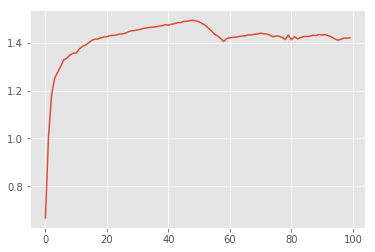

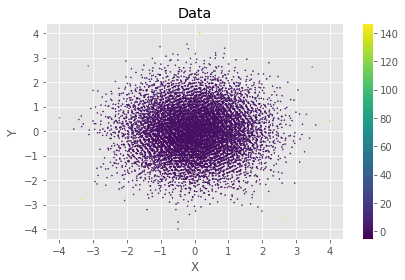

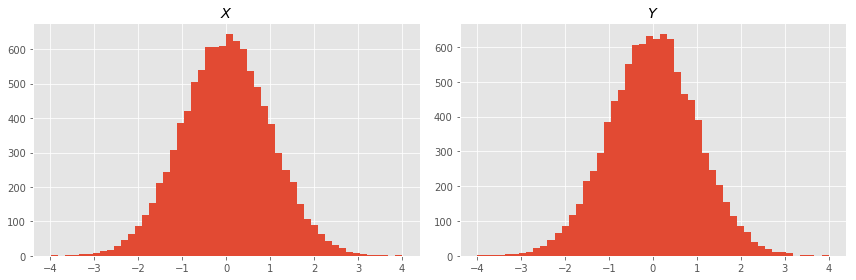

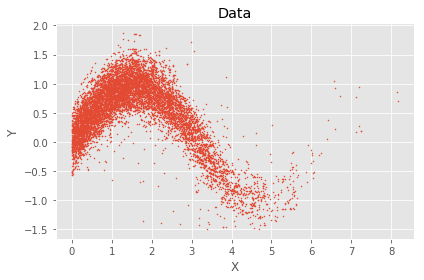

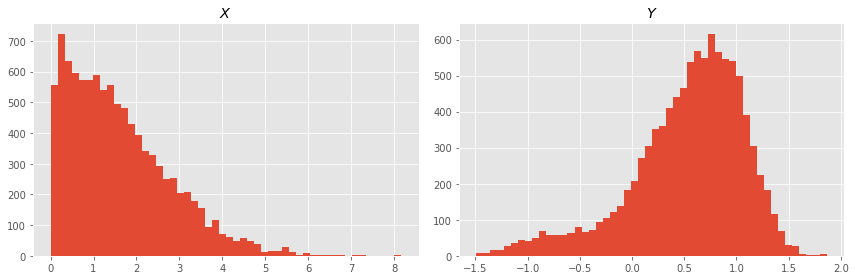

In [232]:
n_layers = 100       # Arbitrary number of layers
random_state = 123 

# Initialize Deep RBIG model
deep_rbig_model = DeepDestructor(
    canonical_destructor=rbig_model,
    n_canonical_destructors=n_layers, 
    random_state=random_state
)

deep_rbig_model.fit(data);




# Get Scores
# data_samples = deep_rbig_model.sample(100, random_state=123)
score = deep_rbig_model.score(data)
score_layers = deep_rbig_model.score_layers(data)
probs = deep_rbig_model.score_samples(data)
print('Score:', score)

plot_layer_scores(score_layers)

# Data in Gaussian Domain
Z_approx = deep_rbig_model.transform(data)

plot_scatter(Z_approx, probs)

plot_histograms(Z_approx)


# Generate Samples in Data Domain
U = np.random.randn(10000, 2)
data_approx = deep_rbig_model.inverse_transform(U)

plot_scatter(data_approx)

plot_histograms(data_approx)



## Randomized Linear Destructor (Paper Version)

Score: 1.6858345634592806


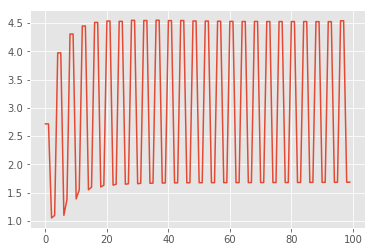

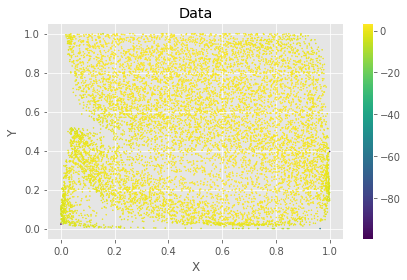

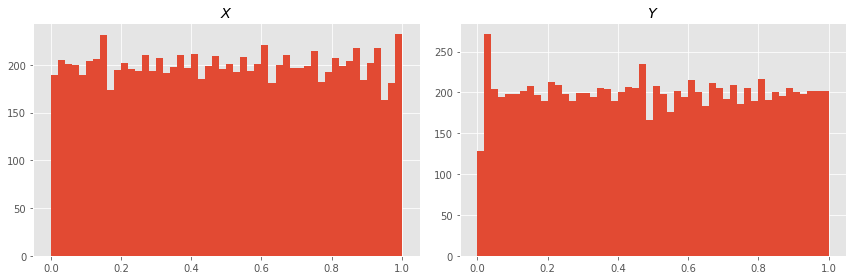

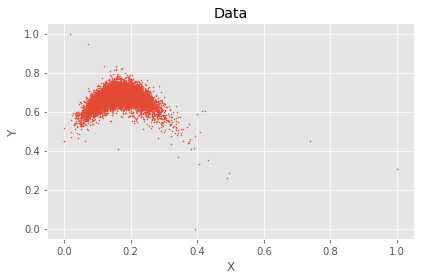

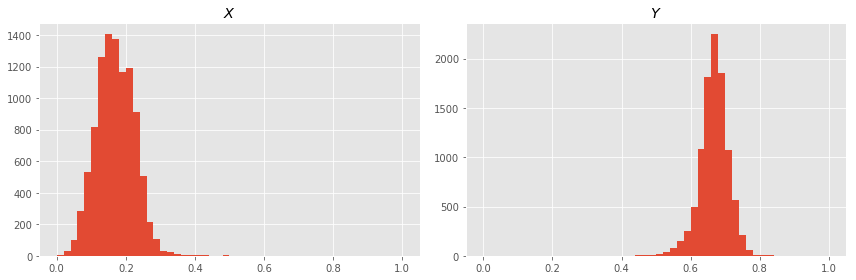

In [299]:
# Parameters
n_layers = 100
bins = 'auto'
bounds = [0, 1]
alpha = 10

# Choose the Histogram estimator that converts the data X to uniform U(0,1)
univariate_estimator = HistogramUnivariateDensity(bounds=bounds, bins=bins, alpha=alpha)

# Marginally uses histogram estimator
marginal_uniformization = IndependentDensity(
    univariate_estimators= univariate_estimator,
)

# Creates "Destructor" D_theta_1
uniform_density = IndependentDestructor(marginal_uniformization)



# Composite Destructor
deep_rand_lin_destructor = DeepDestructor(
    canonical_destructor = 
    [
        clone(marginal_gaussianization),                # Marginal Gaussianization
        clone(rotation),                                # Rotation (Random Orthogonal)
        IndependentDestructor(),                        # Project Data into Unit HyperCube
        clone(uniform_density)                          # Marginal Uniformization
    ],
    n_canonical_destructors=n_layers,
    random_state=123
)

deep_rand_lin_destructor.fit(data)


# Get Scores
# data_samples = deep_rbig_model.sample(100, random_state=123)
score = deep_rand_lin_destructor.score(data)
score_layers = deep_rand_lin_destructor.score_layers(data)
probs = deep_rand_lin_destructor.score_samples(data)
print('Score:', score)

plot_layer_scores(score_layers)

# Data in Gaussian Domain
Z_approx = deep_rand_lin_destructor.transform(data)

plot_scatter(Z_approx, probs)

plot_histograms(Z_approx)


# Generate Samples in Data Domain
U = np.random.randn(10000, 2)
data_approx = deep_rand_lin_destructor.inverse_transform(U)

plot_scatter(data_approx)

plot_histograms(data_approx)


## Randomized Linear Destructor (Closer to RBIG Version)

Score: 4.632380288374791


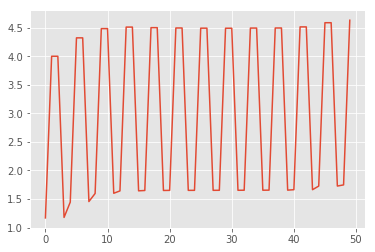

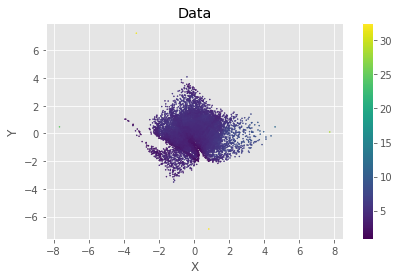

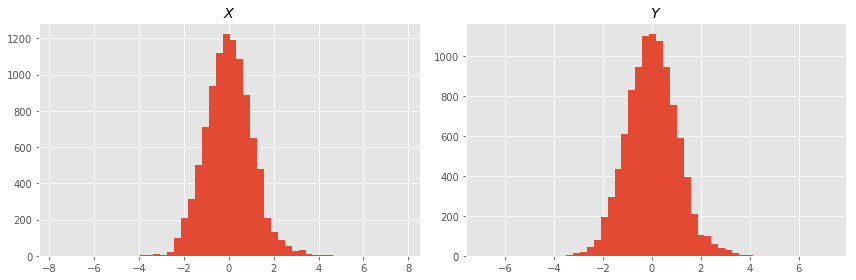

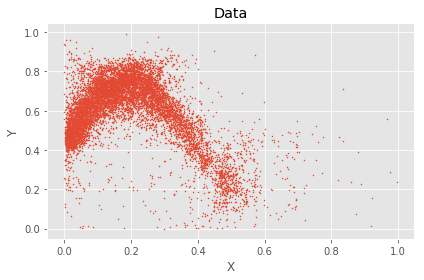

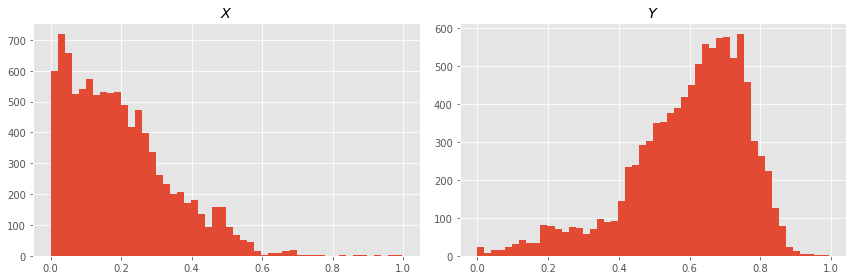

In [238]:
# Parameters
n_layers = 50
bins = 'auto'
bounds = [0, 1]
alpha = 1



# Composite Destructor
rand_lin_destructor = DeepDestructor(
    [
        clone(uniform_density),                         # Marginal Uniformization
        clone(marginal_gaussianization),                # Marginal Gaussianization
        clone(rotation),                                # Rotation (Random Orthogonal)
        IndependentDestructor(),                        # Project Data into Unit HyperCube
    ],
    n_canonical_destructors=n_layers,
)

rand_lin_destructor.fit(data)


# Get Scores
# data_samples = deep_rbig_model.sample(100, random_state=123)
score = rand_lin_destructor.score(data)
score_layers = rand_lin_destructor.score_layers(data)
probs = rand_lin_destructor.score_samples(data)
print('Score:', score)

plot_layer_scores(score_layers)

# Data in Gaussian Domain
Z_approx = rand_lin_destructor.transform(data)

plot_scatter(Z_approx, probs)

plot_histograms(Z_approx)


# Generate Samples in Data Domain
U = np.random.randn(10000, 2)
data_approx = rand_lin_destructor.inverse_transform(U)

plot_scatter(data_approx)

plot_histograms(data_approx)



## Deep Density Destructor (Gaussian Copula)

They require canonical destructors to be bounded to the unit hyperCube domain.

Score: -2.810162820212043


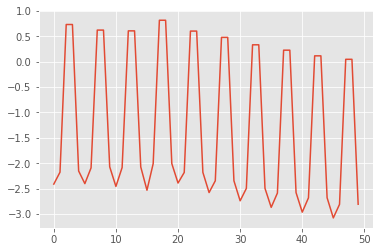

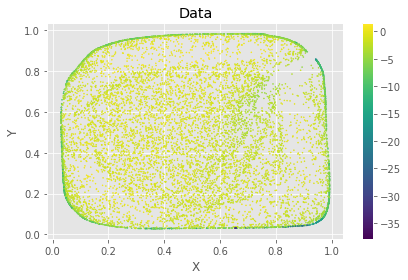

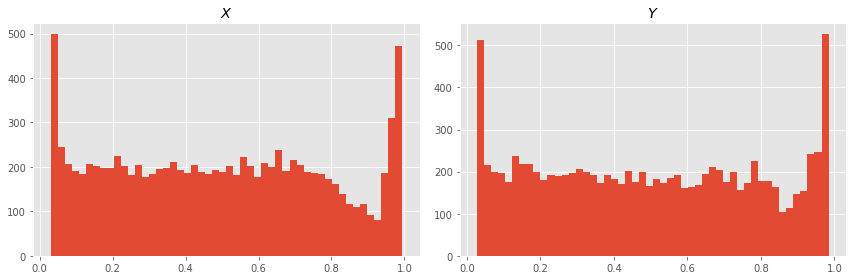

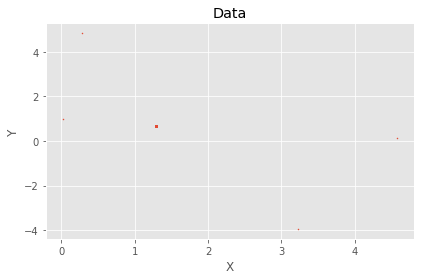

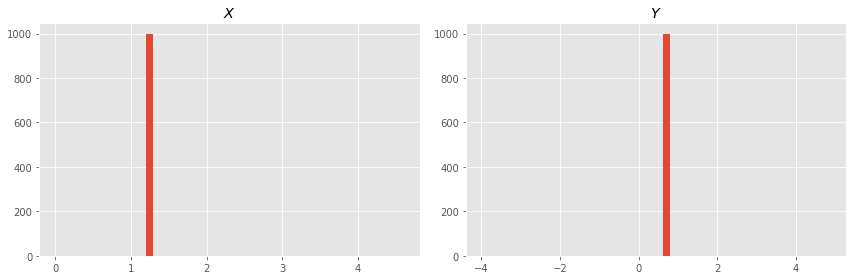

In [245]:
# Parameters
n_layers = 50
bins = 'auto'
bounds = [0, 1]
alpha = 10

init_transform = IndependentDestructor()

# Step I - Marginal Uniformization
marginal_uniformization = IndependentDensity(
    univariate_estimators=HistogramUnivariateDensity(bounds=bounds, bins=bins, alpha=alpha),
)

uniform_density = IndependentDestructor(marginal_uniformization)

# Step II - Marginal Gaussianization
marginal_gaussianization = IndependentInverseCdf()

# Step III - Rotation
rotation = LinearProjector(linear_estimator=PCA())


# Composite Destructor
deep_copula_model = DeepDestructor(
[
    clone(IndependentDestructor()),                 # Project Data into Unit HyperCube
    clone(uniform_density),                         # Marginal Uniformization
    clone(marginal_gaussianization),                # Marginal Gaussianization
    clone(rotation),                                # Rotation (PCA)
    clone(IndependentDestructor())                 # Project Data into Unit HyperCube
], n_canonical_destructors=n_layers
)

deep_copula_model.fit(data)

# Get Scores
# data_samples = deep_rbig_model.sample(100, random_state=123)
score = deep_copula_model.score(data)
score_layers = deep_copula_model.score_layers(data)
probs = deep_copula_model.score_samples(data)
print('Score:', score)

plot_layer_scores(score_layers)

# Data in Gaussian Domain
Z_approx = deep_copula_model.transform(data)

plot_scatter(Z_approx, probs)

plot_histograms(Z_approx)


# Generate Samples in Data Domain
U = np.random.uniform(0, 1, (10000 ,2))
data_approx = deep_copula_model.inverse_transform(U)
data_approx = deep_copula_model.sample(1000, 123)

plot_scatter(data_approx)

plot_histograms(data_approx)



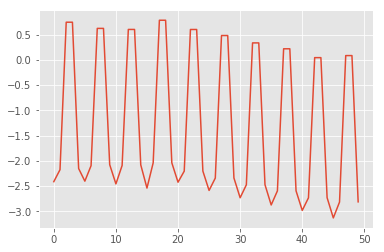

In [235]:
fig, ax = plt.subplots()

ax.plot(score_layers.cumsum())

plt.show()

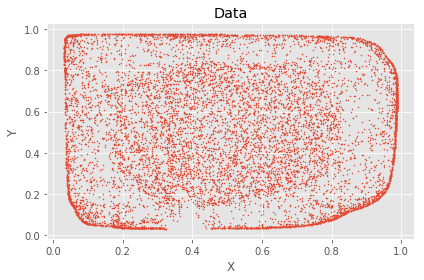

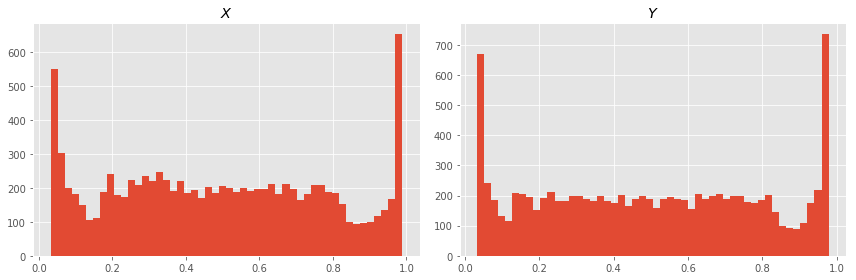

In [236]:

# Data Together
plot_scatter(Z_approx)

# Histograms
plot_histograms(Z_approx)

## Cross Validation Strategies

#### RBIG - Deep Destructor Cross Validated

Score: 3.4519003576588503


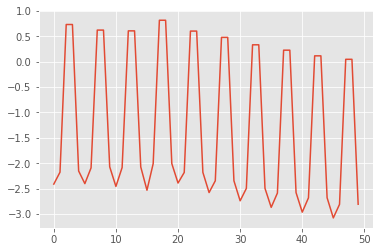

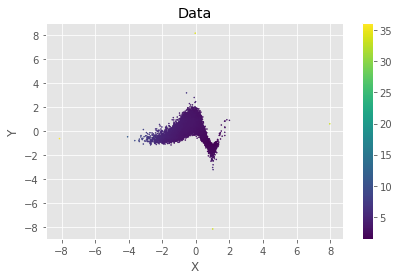

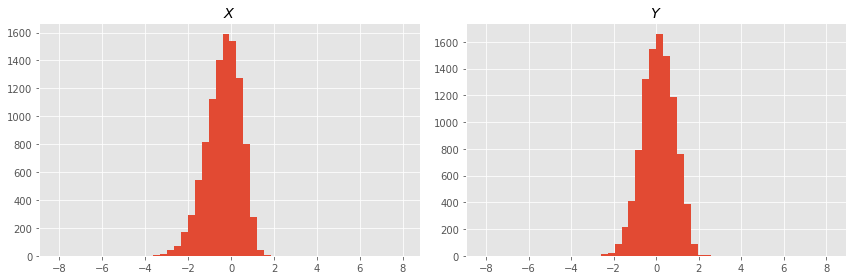

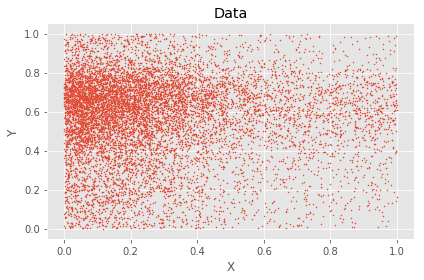

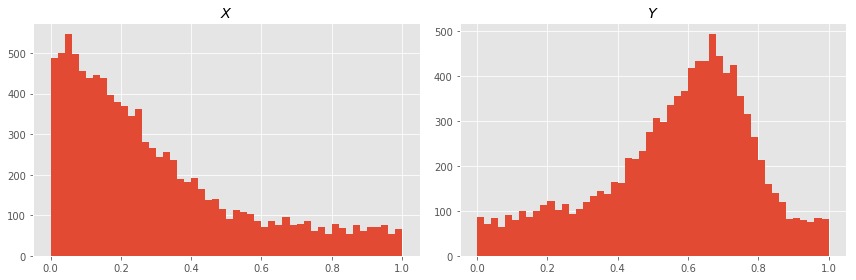

CPU times: user 2.29 s, sys: 37 ms, total: 2.33 s
Wall time: 2.2 s


In [250]:
%%time 

# Parameters
n_layers = 1000
bins = 'auto'
bounds = [0, 1]
alpha = 100

init_transform = IndependentDestructor()

# Step I - Marginal Uniformization
marginal_uniformization = IndependentDensity(
    univariate_estimators=HistogramUnivariateDensity(bounds=bounds, bins=bins, alpha=alpha),
)

uniform_density = IndependentDestructor(marginal_uniformization)

# Step II - Marginal Gaussianization
marginal_gaussianization = IndependentInverseCdf()

# Step III - Rotation
rotation = LinearProjector(linear_estimator=PCA())


# Composite Destructor
rbig_deep_cv_model = DeepDestructorCV(
    init_destructor=None, 
    canonical_destructor = 
    [
        clone(uniform_density),                         # Marginal Uniformization
        clone(marginal_gaussianization),                # Marginal Gaussianization
        clone(rotation),                                # Rotation (PCA)
    ],
    n_extend=1,
    cv=5,
    random_state=123,
    stop_tol=0.1,
    refit=True,
    max_canonical_destructors=50
    
)

# Z_approx = rbig_deep_cv_model.fit_transform(data)
rbig_deep_cv_model.fit(data)


# Get Scores
# data_samples = deep_rbig_model.sample(100, random_state=123)
score = rbig_deep_cv_model.score(data)
score_layers = rbig_deep_cv_model.score_layers(data)
probs = rbig_deep_cv_model.score_samples(data)
print('Score:', score)

plot_layer_scores(score_layers)

# Data in Gaussian Domain
Z_approx = rbig_deep_cv_model.transform(data)

plot_scatter(Z_approx, probs)

plot_histograms(Z_approx)


# Generate Samples in Data Domain
G = np.random.randn(10000 ,2)
data_approx = rbig_deep_cv_model.inverse_transform(G)
# data_approx = rbig_deep_cv_model.sample(1000, 123)

plot_scatter(data_approx)

plot_histograms(data_approx)

### Deep Copula Model (Cross-Validated)

Score: 0.819659315097093


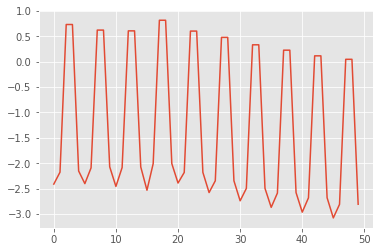

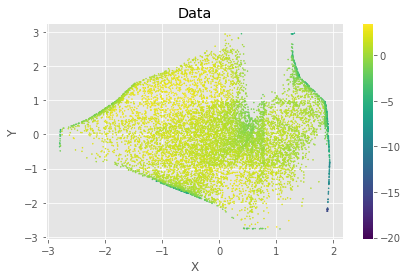

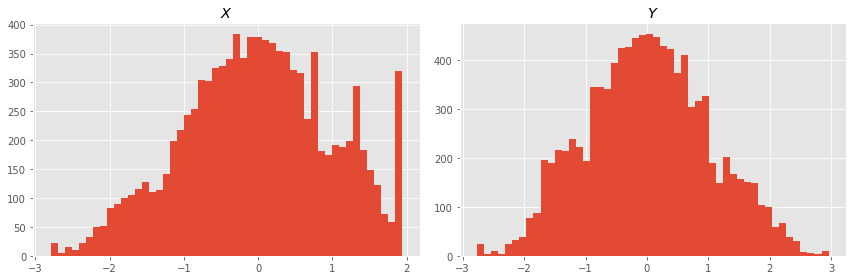

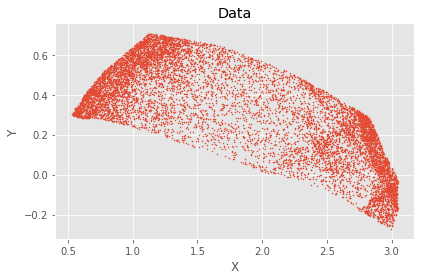

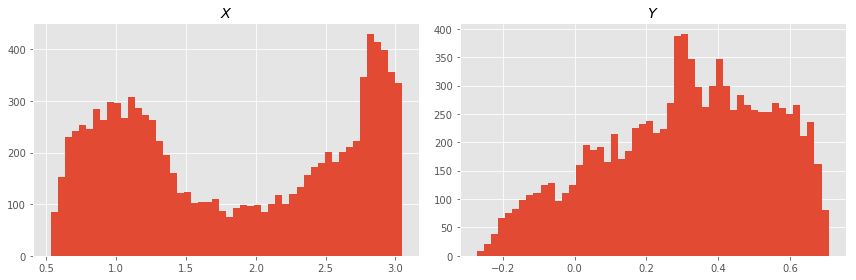

CPU times: user 3.18 s, sys: 79.5 ms, total: 3.26 s
Wall time: 2.92 s


In [252]:
%%time 

# Parameters
n_layers = 1000
bins = 'auto'
bounds = [0, 1]
alpha = 10

init_transform = IndependentDestructor()

# Step I - Marginal Uniformization
marginal_uniformization = IndependentDensity(
    univariate_estimators=HistogramUnivariateDensity(bounds=bounds, bins=bins, alpha=alpha),
)

uniform_density = IndependentDestructor(marginal_uniformization)

# Step II - Marginal Gaussianization
marginal_gaussianization = IndependentInverseCdf()

# Step III - Rotation
rotation = LinearProjector(linear_estimator=PCA())


# Composite Destructor
deep_copula_cv_model = DeepDestructorCV(
    init_destructor=None, 
    canonical_destructor = 
    [
        clone(IndependentDestructor()),                 # Project Data into Unit HyperCube
        clone(uniform_density),                         # Marginal Uniformization
        clone(marginal_gaussianization),                # Marginal Gaussianization
        clone(rotation),                                # Rotation (PCA)
        clone(IndependentDestructor())                 # Project Data into Unit HyperCube
    ],
    n_extend=20,
    cv=3,
)

deep_copula_cv_model.fit(data)


# Get Scores
# data_samples = deep_rbig_model.sample(100, random_state=123)
score = deep_copula_cv_model.score(data)
score_layers = deep_copula_cv_model.score_layers(data)
probs = deep_copula_cv_model.score_samples(data)
print('Score:', score)

plot_layer_scores(score_layers)

# Data in Gaussian Domain
Z_approx = deep_copula_cv_model.transform(data)

plot_scatter(Z_approx, probs)

plot_histograms(Z_approx)


# Generate Samples in Data Domain
U = np.random.uniform(0,1, (10000 ,2))
data_approx = deep_copula_cv_model.inverse_transform(U)
# data_approx = rbig_deep_cv_model.sample(1000, 123)

plot_scatter(data_approx)

plot_histograms(data_approx)

### Randomized Linear Destructor

Score: 1.109902095299307


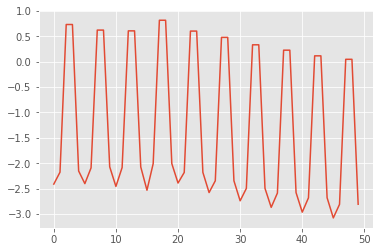

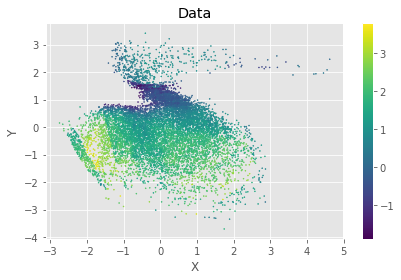

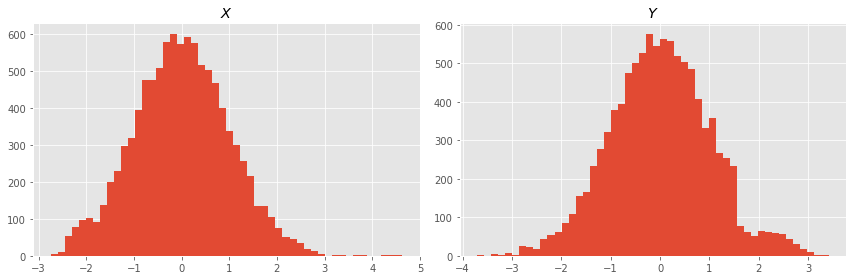

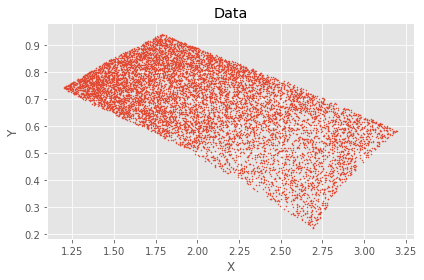

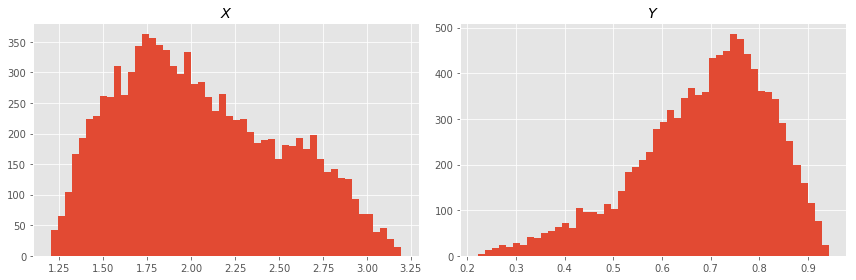

CPU times: user 2.79 s, sys: 57.2 ms, total: 2.85 s
Wall time: 2.91 s


In [262]:
%%time

# Parameters
n_extend = 50
bins = 'auto'
bounds = [0, 1]
alpha = 1e-10

init_transform = IndependentDestructor()



# Step I - Marginal Gaussianization
marginal_gaussianization = IndependentInverseCdf()

# Step II - Rotation
rotation = LinearProjector(RandomOrthogonalEstimator(), orthogonal=True)

# Step III - Marginal Uniformization
marginal_uniformization = IndependentDensity(
    univariate_estimators=HistogramUnivariateDensity(bounds=bounds, bins=bins, alpha=alpha),
)

uniform_density = IndependentDestructor(marginal_uniformization)

# Composite Destructor
deep_linear_cv_destructor = DeepDestructorCV(
    init_destructor=IndependentDestructor(),            # Initially project into Unit HyperCube
    canonical_destructor = 
    [
        clone(marginal_gaussianization),                # Marginal Gaussianization
        clone(rotation),                                # Rotation (Random Orthogonal)
        IndependentDestructor(),                        # Project Data into Unit HyperCube
        clone(uniform_density)                          # Marginal Uniformization
    ],
    n_extend=20,
    cv=3,
    stop_tol=1e-3,
    refit=True,
    random_state=True
)

deep_linear_cv_destructor.fit(data)


# Get Scores
# data_samples = deep_rbig_model.sample(100, random_state=123)
score = deep_linear_cv_destructor.score(data)
score_layers = deep_linear_cv_destructor.score_layers(data)
probs = deep_linear_cv_destructor.score_samples(data)
print('Score:', score)

plot_layer_scores(score_layers)

# Data in Gaussian Domain
Z_approx = deep_linear_cv_destructor.transform(data)

plot_scatter(Z_approx, probs)

plot_histograms(Z_approx)


# Generate Samples in Data Domain
U = np.random.uniform(0, 1, (10000 ,2))
data_approx = deep_linear_cv_destructor.inverse_transform(U)
# data_approx = deep_linear_cv_destructor.density_.sample(1000, 123)

plot_scatter(data_approx)

plot_histograms(data_approx)

## Randomized Linear Destructor (Closer to RBIG Version)

Score: 4.598805787913552


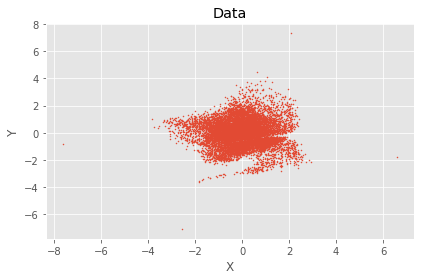

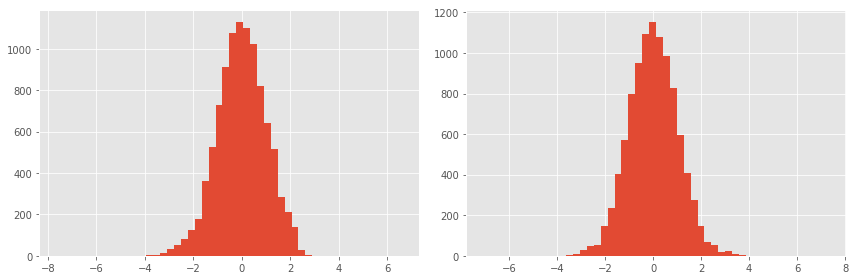

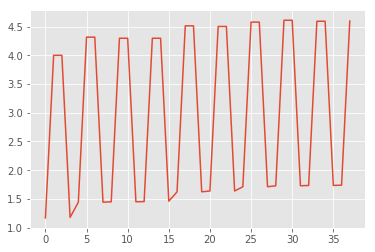

CPU times: user 2.48 s, sys: 55.3 ms, total: 2.53 s
Wall time: 2.55 s


In [194]:
%%time

# Parameters
n_extend = 50
bins = 'auto'
bounds = [0, 1]
alpha = 1


# Step I - Marginal Gaussianization
marginal_gaussianization = IndependentInverseCdf()

# Step II - Rotation
rotation = LinearProjector(RandomOrthogonalEstimator(), orthogonal=True)
# rotation = LinearProjector(linear_estimator=PCA())

# Step III - Marginal Uniformization
marginal_uniformization = IndependentDensity(
    univariate_estimators=HistogramUnivariateDensity(bounds=bounds, bins=bins, alpha=alpha),
)

uniform_density = IndependentDestructor(marginal_uniformization)

# Composite Destructor
deep_linear_destructor = DeepDestructorCV(
    init_destructor=None,            
    canonical_destructor = 
    [
        clone(uniform_density),                         # Marginal Uniformization
        clone(marginal_gaussianization),                # Marginal Gaussianization
        clone(rotation),                                # Rotation (Random Orthogonal)
        IndependentDestructor(),                        # Project Data into Unit HyperCube
        
    ],
    n_extend=n_extend,
    cv=3,
)

Z_approx = deep_linear_destructor.fit_transform(data)


score = deep_linear_destructor.score(data)
score_layers = deep_linear_destructor.score_layers(data)
probs = deep_linear_destructor.score_samples(data)
print('Score:', score)

# Data Together
plot_scatter(Z_approx)

# Histograms
plot_histograms(Z_approx)


